In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from keplergl import KeplerGl
from scipy import stats
import plotly.express as px

pd.options.display.max_columns=9999
plt.style.use("ggplot")
%matplotlib inline

In [2]:
df = pd.read_csv("Data/ESPA_Deltas_All_Rounds.csv", low_memory=False)

In [3]:
lands = pd.read_excel("Data/ESPA_DELTAS_LAND_COVER.xlsx", header=4)
listing = pd.read_csv("Data/ESPA_Deltas_Listing.csv")
sample = pd.read_excel("Documentation/ESPA_DELTAS_LOCATIONS.xlsx", header=[1,2,3,4])

In [5]:
sample = sample.fillna(method='pad')
sample = sample.rename(columns=lambda x: x if not 'Unnamed' in str(x) else '')
sample = sample.rename(columns={'index':'ColA'})
sample.columns.names = (None, None, None, None)
sample.columns = ["Social Economic Zone", "Division Name", "District Name", "Thana Name",
                  "Selected Union", "Selected Mouza", "Total Households", "Population", 
                  "Floating", "Total Population", "Population density[sq. km]", "Geocode"]

In [93]:
geocode = gpd.read_file("districts.geojson")
population = dict(sample.groupby("District Name")["Population"].sum() / sample.groupby("District Name")["Total Households"].sum())
geocode["Population"] = geocode["ADM2_EN"].apply(lambda x: population.get(x, 0))

In [96]:
# Regions covered by this dataset
map_1 = KeplerGl()
map_1.add_data(data=geocode, name="map")
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'map': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,…

In [12]:
# Average household size for each region (actual)
population

{'Bagerhat': 4.039616935483871,
 'Barguna': 4.029301453352086,
 'Barisal': 4.777602167532175,
 'Bhola': 4.75868652157312,
 'Khulna': 4.569152326322499,
 'Patuakhali': 4.5576947118389795,
 'Pirojpur': 4.452387524151256,
 'Satkhira': 4.392775838518744}

In [19]:
# Average household size from the survey data
pd.to_numeric(df["HMEMBER"], errors = "coerce").fillna(0).mean()

4.997898276586801

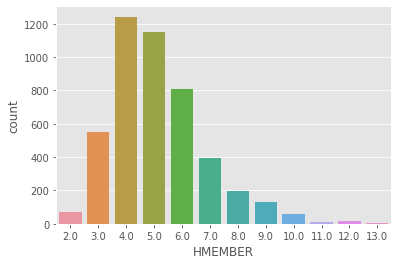

In [163]:
# Distribution of household size
sns.countplot(x=pd.to_numeric(df["HMEMBER"], errors = "coerce"))

In [124]:
# Explore occupation data and how they relate to househols income
occupation_code = {1: "Agriculture(own land)", 2: "Agriculture(share crops)", 3:"Agriculture(Mortgage/Kot/Poshani)",
                   4: "Day labourer(agricultural)", 5: "Day labourer(off-farm)", 6: "Catching fish & selling fish",
                   7: "Handicraft", 8: "Off-farm skilled labour", 9: "Business (small/mobile/hawker)", 
                   10: "Business (Large/company)", 11: "Salaried employment (service)", 12: "Pension",
                   13: "Remittance (within country)", 14: "Remittance (other country)", 15: "VGD/old age/destitute allowance",
                   16: "Renting house/shop (renting out)", 17: "Rickshaw/van pulling/Boatman", 18: "Carpentry and masonry", 
                   19: "Goat/Cattle/chicken/duck farm", 20: "Aquaculture/fish farm", 21: "Forest collector", 
                   96: "others"}

summary = pd.read_csv("Data/ESPA_Deltas_Listing.csv")
summary = summary[(np.abs(stats.zscore(summary["H09"])) < 3)]
summary["H06"] = summary["H06"].apply(lambda x: occupation_code.get(x, "None"))
summary["H07"] = pd.to_numeric(summary["H07"], errors="coerce").apply(lambda x: occupation_code.get(x, "None"))
summary["H08"] = pd.to_numeric(summary["H08"], errors="coerce").apply(lambda x: occupation_code.get(x, "None"))

In [152]:
summary.head()

,ZONE,DIVISION,DISTRICT,UPAZILA,UNION,MOUZA,SEGMENT,LISTEDH,HHNO,H03,H04,H06,H07,H08,H09,H10,H11,H12
0,1,1,6,36,81,356,1,150,1,1,50,Business (small/mobile/hawker),None,None,20000,8,5,3
1,1,1,6,36,81,356,1,150,2,1,45,Business (Large/company),None,None,70000,1,1,1
2,1,1,6,36,81,356,1,150,3,1,30,Business (small/mobile/hawker),None,None,8000,8,3,3
3,1,1,6,36,81,356,1,150,4,1,33,Day labourer(agricultural),None,None,6000,8,7,3
4,1,1,6,36,81,356,1,150,5,1,30,Business (small/mobile/hawker),None,None,10000,8,3,3


In [62]:
# Statistics about average monthly household income
summary.H09.describe()

count     9302.000000
mean      7730.543969
std       5968.537408
min        500.000000
25%       5000.000000
50%       6000.000000
75%       9000.000000
max      70000.000000
Name: H09, dtype: float64

In [90]:
# Average monthly household income and its distribution (taka)
print("Average monthly household income(in taka): {}".format(summary.H09.mean()))

Average monthly household income(in taka): 7730.543969038917


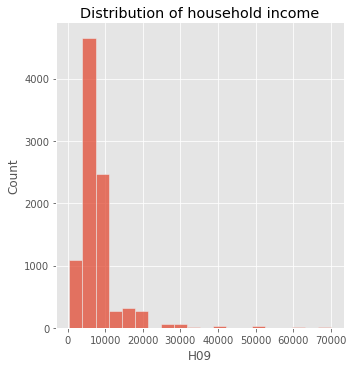

In [175]:
# Household income distribution
sns.displot(summary, x="H09", palette="muted", bins=20)
plt.title("Distribution of household income");

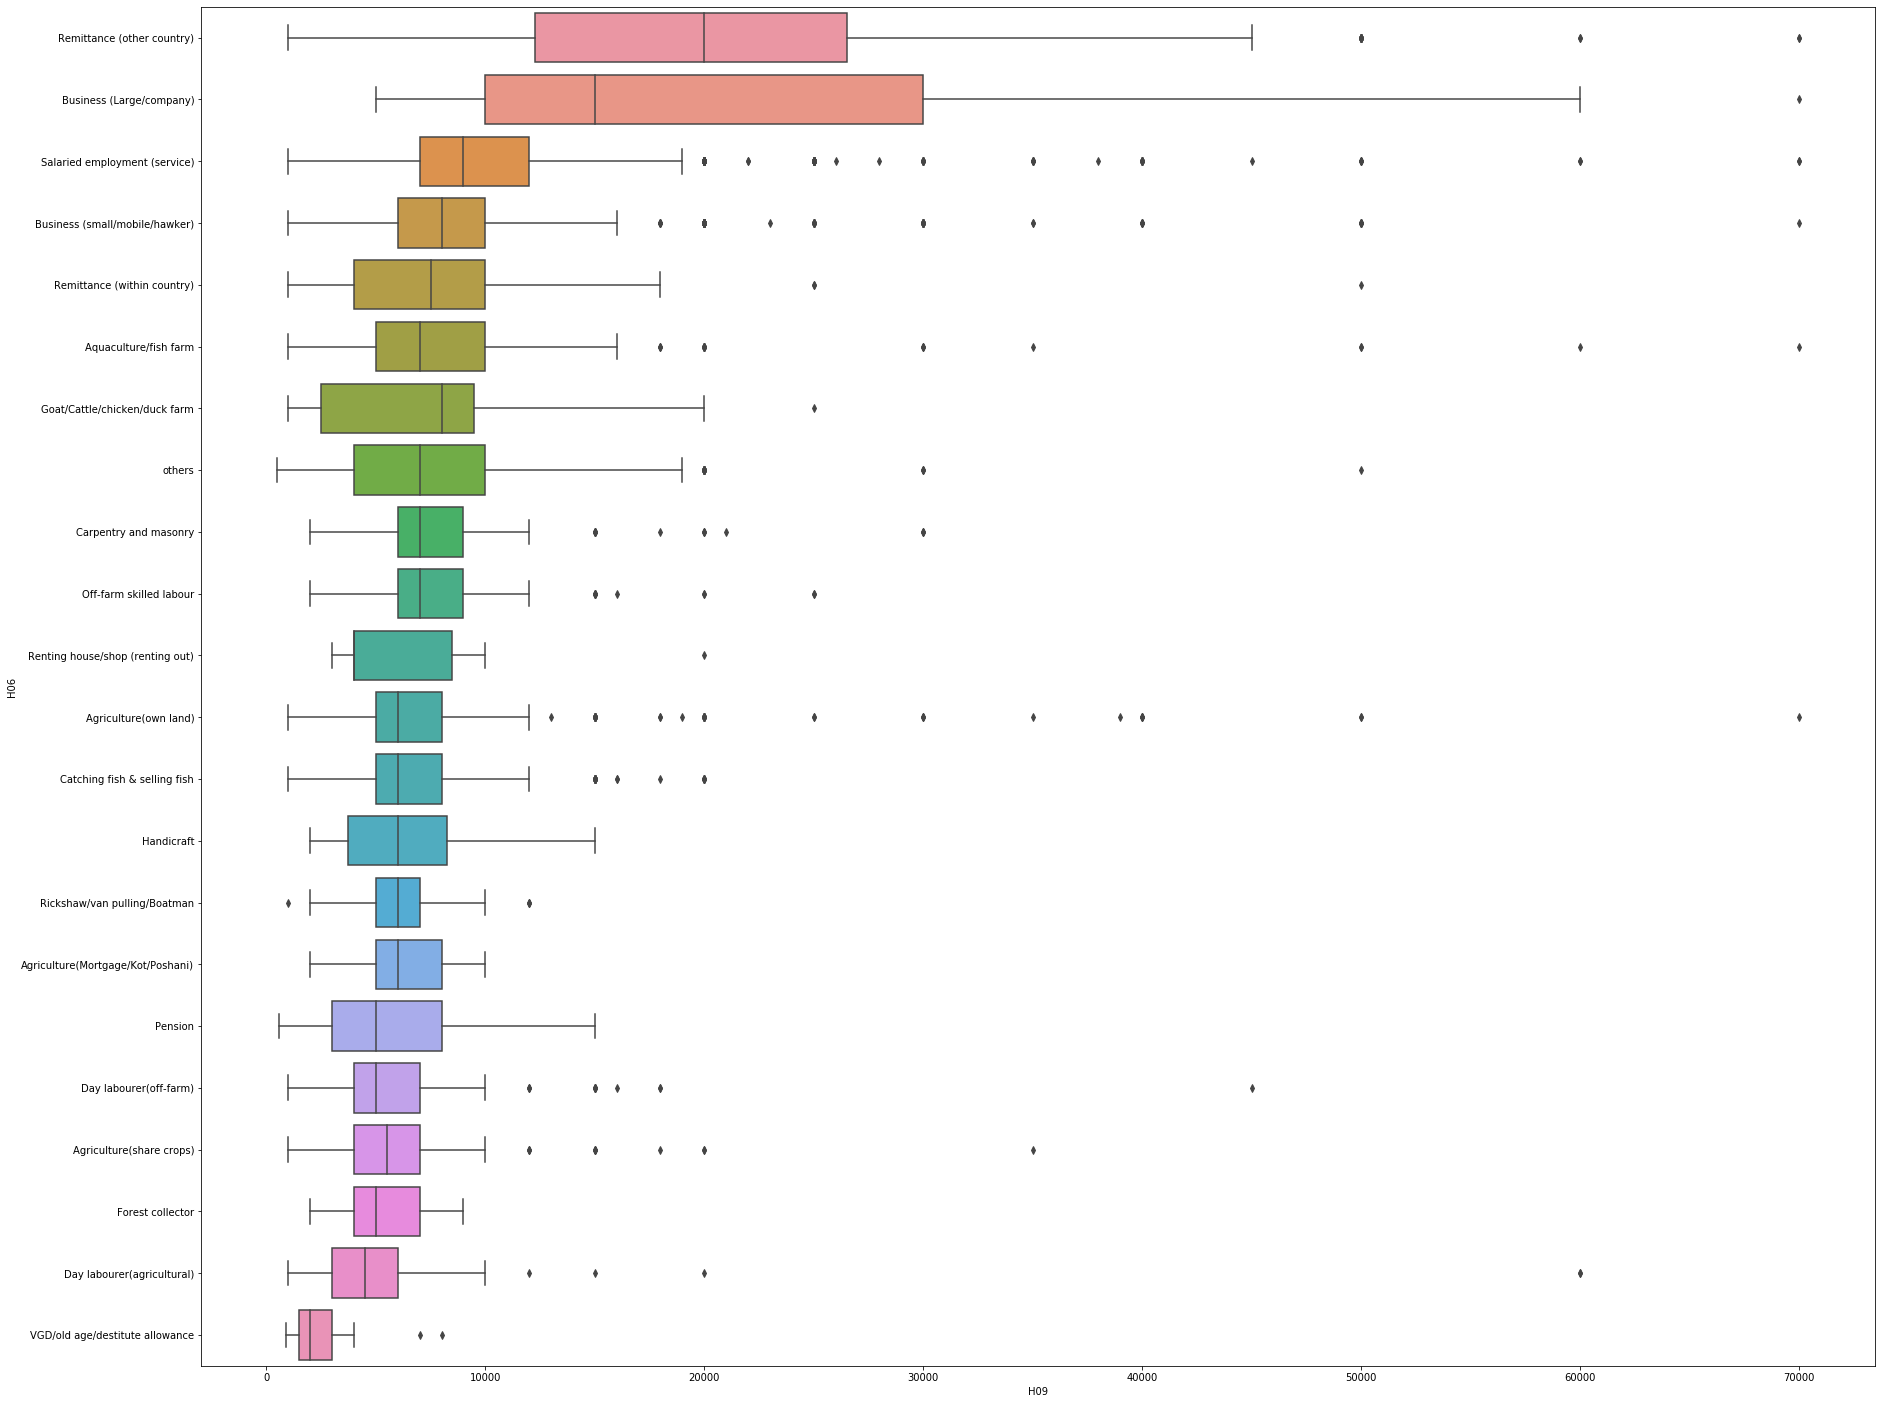

In [74]:
# Distribution of household income for each occupation
plt.figure(figsize=(30, 25))
ranking = summary.groupby("H06")["H09"].mean().sort_values(ascending=False).index
plot = sns.boxplot(x="H09", y="H06", data=summary, order=ranking)

In [143]:
# Distribution of occpations
counts = pd.DataFrame(summary["H06"].value_counts())

fig = px.pie(counts, values="H06", names=counts.index)
fig

In [148]:
# Distribution of the alternative opportunities for agriculture (Households with first choice as agriculture)
agriculture = summary[summary["H06"].str.contains("Agriculture")]
agriculture_alternatives = pd.DataFrame(pd.concat([agriculture["H07"], agriculture["H08"]], axis=0).value_counts().drop("None"))
fig = px.pie(agriculture_alternatives, values=0, names=agriculture_alternatives.index)
fig.update_traces(textposition='outside', textinfo='percent+label', showlegend=False)

#  Next week
**1, Land size**
**2, How many people work on the land**